In [1]:
!python --version

Python 3.6.3


# Classifying Chinese Dialect Audio with Varying Length

This is a part of competition at [2018 iFlyTek](http://challenge.xfyun.cn/) ,[方言种类识别AI挑战赛](http://challenge.xfyun.cn/aicompetition/techDetail). 

The challenge is to classify audio data into 6 different chinese dialect namely:

English Name | 中文名称
-- | --
ChangSa|长沙
HeBei|河北
ShangHai|上海
NanChang | 南昌
MinNan | 闽南
KeJia | 客家

## Our Method
1. Conversion of PCM to WAV Format __(Data Preprocessing)__
2. Trimming of WAV files __(Data Preprocessing)__
3. 



## Requirements
1. librosa - audio analytic tools
2. _Please strive to fill in this_

## 1. Downloading Requirements

So we will start with installing libraries, and packages with `pip`:
1. Librosa - Audio analytic library
2. PyDrive - Google drive 
3. 



In [1]:
%%bash
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
pip install librosa
pip install -U -q PyDrive
pip install cPickle

Cache entry deserialization failed, entry ignored
  Could not find a version that satisfies the requirement cPickle (from versions: )
No matching distribution found for cPickle


In [2]:
%%bash
apt-get install libav-tools

Reading package lists...
Building dependency tree...
Reading state information...
libav-tools is already the newest version (7:3.3.4-2).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


### Downloading Files
>1 |  Setting Up Drive libraries and connection. (_Code from searching drive in Code snippets tab_)

In [3]:
### Run this
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("successful!")

successful!


> 2 |  Listing all the available files. [_ref_](https://pythonhosted.org/PyDrive/filelist.html#get-all-files-which-matches-the-query)
1. Getting `preEditedAudio` folder's id
2. Getting the list of folder `changsa` ...
3. Using `for ... in ...` loop to find the train folder

```
Current Folder Structure In Google Drive :
audio
preEditedAudio - to be downloaded
    | changsa
          | .vs
          | dev
          | train <- What we wanted
                  | speaker01
                  | speaker02
                  .
                  .
                  .
                  | speaker29
                  | speaker30
          | .DS_Store
          | changsha.dev.mlf
          | changsha.train.mlf
    | changsa
          | .vs
          | dev
          | train <- What we wanted
                  | speaker01
                  | speaker02
                  .
                  .
                  .
                  | speaker29
                  | speaker30
          | .DS_Store
          | changsha.dev.mlf
          | changsha.train.mlf
    .
    .
    .
```

We then created an array to keep the `file['id']` of the train and dev folder. _To futher download them later_
```
Master Parent File Array
name : changSha
train : [
                            {
                                        title : speaker01
                                        id : SPEAKER01ID
                            },
                            {
                                        title : speaker02
                                        id : SPEAKER02ID
                            },
                            .
                            .
                            .
                            {
                                        title : speaker30
                                        id : SPEAKER30ID
                            }
                    ]
dev : [
                            {
                                        title : speaker31
                                        id : SPEAKER31ID
                            },
                            {
                                        title : speaker32
                                        id : SPEAKER32ID
                            },
                            .
                            .
                            .
                            {
                                        title : speaker35
                                        id : SPEAKER35ID
                            }
                  ]
```
You can use [JSON Beautifier](https://jsonformatter.curiousconcept.com/) to see the file structure of masterParentFile after generated

In [0]:
parentId = drive.ListFile({'q': "title='preEditedAudio'"}).GetList()[0]['id']
file_list = drive.ListFile({'q': "'"+parentId+"' in parents and trashed=false"}).GetList()
masterParentIndex = 0
masterParentFile = []
childTrainFileList = []
childDevFileList = []
for file in file_list:
  childTrainFileList = []
  childDevFileList = []
  print('title: %s , id: %s' % (file['title'],file['id']))
  for childFile in drive.ListFile({'q': "'"+file['id']+"' in parents and trashed=false"}).GetList():
    if(childFile['title'] == 'train'):
        print(childFile['id'])
        for grandChildFile in drive.ListFile({'q': "'"+childFile['id']+"' in parents and trashed=false and title contains 'speaker'"}).GetList():
            grandChildTrainFileList = []
            for grandgrandChildFile in drive.ListFile({'q': "'"+grandChildFile['id']+"' in parents and trashed=false and not title contains '.DS_Store'"}).GetList():
                grandChildTrainFileList.append({
                    "title":grandgrandChildFile['title'],
                     "id":grandgrandChildFile['id']
                })
            childTrainFileList.append({
                "title":grandChildFile['title'],
                "id":grandChildFile['id'],
                "child":grandChildTrainFileList
            })
    elif(childFile['title'] == 'dev'):
        print(childFile['id'])
        for grandChildFile in drive.ListFile({'q': "'"+childFile['id']+"' in parents and trashed=false and title contains 'speaker'"}).GetList():
            grandChildDevFileList =[]
            for grandgrandChildFile in drive.ListFile({'q': "'"+grandChildFile['id']+"' in parents and trashed=false and not title contains '.DS_Store'"}).GetList():
                grandgrandChildDevFileList =[];
                for grandgrandgrandChildFile in drive.ListFile({'q': "'"+grandgrandChildFile['id']+"' in parents and trashed=false and not title contains '.DS_Store'"}).GetList():
                    grandgrandChildFileList.append({
                        "title":grandgrandgrandChildFileList['title'],
                        "id":grandgrandgrandChildFileList['id']
                    })
                grandChildDevFileList.append({
                    "title":grandgrandChildFile['title'],
                     "id":grandgrandChildFile['id'],
                    "child":grandgrandChildFileList
                })
            childDevFileList.append({
                "title":grandChildFile['title'],
                "id":grandChildFile['id'],
                "child":grandChildDevFileList
            })
  masterParentFile.append({
      "name":file['title'],
      "train":childTrainFileList,
      "dev":childDevFileList
  })

print(masterParentFile)
  

title: changsha , id: 1I-J_U7c_VaXREjso02Nhu_YZ63jfmgd0
1mdh-axF319uiLMYTcT-z2T7Tmo_m_81B
1258NMxcNKjEuP7Ypo4e11fBZiPi-ZsoT


NameError: ignored

In [0]:
### Run this

import os

parentId = drive.ListFile({'q': "title='changSaExample1.pcm'"}).GetList()

if not os.path.exists("audio/"):
        os.makedirs("audio/")
download = drive.CreateFile({'id':parentId[0]['id']})
download.GetContentFile('audio/'+parentId[0]['title'])


parentId = drive.ListFile({'q': "title='changSaExample2.pcm'"}).GetList()

if not os.path.exists("audio/"):
        os.makedirs("audio/")
download = drive.CreateFile({'id':parentId[0]['id']})
download.GetContentFile('audio/'+parentId[0]['title'])

In [5]:
%%bash
ls
cd audio
ls

audio
datalab
changSaExample1.pcm
changSaExample1.pcm.wav
changSaExample2.pcm


> 3 | Make a folder to store the audio file. Then get a file, Eg. changSaExample1.pcm

> >`file_id` of  `changSaExample1.pcm` is `1mqNYLgWma_15o-FkdTMDQxAtukYkBYnA`



In [6]:
import os
if not os.path.exists("audio"):
    os.makedirs("audio")

# fileIdArray = ['1mqNYLgWma_15o-FkdTMDQxAtukYkBYnA','1rRfyhACF2WbpY_JseE0Mscbv8YdngKrG']
for file in masterParentFile:
    if not os.path.exists("audio/"+file['name']):
        os.makedirs("audio/"+file['name'])
        os.makedirs("audio/"+file['name']+"/train")
        os.makedirs("audio/"+file['name']+"/dev")
    for trainFile in file['train']:
        print(trainFile['id'])
        download = drive.CreateFile({'id':trainFile['id']})
        print(os.getcwd()) 
        download.GetContentFile('audio/'+file['name']+"/train/"+trainFile['title'])
#     for devFile in file['dev']:
#         drive.CreateFile({'id':devFile['id']}).GetContentFile('audio/'+file['name']+"/dev/"+devFile['title'])
print(os.path.exists("audio/changsha"))
print(drive.ListFile({'q': "'14wXkJNHIfKUbdffrsqCxeoYalcT6Ngke' in parents and trashed=false"}).GetList()[1]['id']);

drive.CreateFile({'id':'1R_NowKuOacLKggVHgWHxHUifKBE4Qzuu'}).GetContentFile('audio/changsha/abc.pcm')

# for index in xrange(len(file_list)):
#   downloaded = drive.CreateFile({'id':file_list[index]['id']})
#   downloaded.GetContentFile('audio/'+file_list[index]['title'])
#   print('Downloaded content %s' % (file_list[index]['title']))

NameError: ignored

> 4 | Show the file content

In [16]:
%%bash
ls
cd audio
ls
rm -rf changSaExample2.pcm.wav
ls
# hod -xc changSaExample1.pcm

audio
datalab
changSaExample1.pcm
changSaExample2.pcm
changSaExample1.pcm
changSaExample2.pcm


_Next Step :_

## 2. Conversion of data from PCM _(Raw Data)_ to WAV

#### Purpose: Because WAV file is much more abundance in the Python enviorment, and more library supported it. As [WAV files can also store raw PCM data](https://stackoverflow.com/questions/560011/compressed-and-uncompressed-wav-files) without compression so we will not lose any significant quality.

The `WAV` format is a part of the [PCM,Pulse-Code Modulation Family](https://en.wikipedia.org/wiki/Pulse-code_modulation). There is few ways of how PCM is used such as, __Linear pulse-code modulation (LPCM)__ , 



#### PCM's Basic Property:
1. __Sampling Rate__ , _number of times per second that samples are taken_
2. __Bit Depth__, _number of possible digital values that can be used to represent each sample_


> The Sample data given is in __16 Bit little endian__ and __16000Hz Sampling Rate__ 

The code here is referenced from https://stackoverflow.com/questions/16111038/how-to-convert-pcm-files-to-wav-files-scripting

In [0]:
### Run this

# imports for library
#@title Default title text
import sys
import wave
import librosa

In [17]:
### Run this


fileNameArray= ["audio/changSaExample1.pcm","audio/changSaExample2.pcm"];

def pcmToWav(fileName,destination):
    pcmfile = open(fileName, 'rb')
    pcmdata = pcmfile.read()
    pcmfile.close()
    
    print(destination+".wav")
    wavfile = wave.open(destination+'.wav', 'wb')
    wavfile.setparams((1, 2, 16000, 0, 'NONE', 'NONE'))
    wavfile.writeframes(pcmdata)
    wavfile.close()

for arg in fileNameArray:
    pcmToWav(arg,arg)
  



audio/changSaExample1.pcm.wav
audio/changSaExample2.pcm.wav


> 1 | Visualising the files.

In [40]:
%%bash
cd audio
ls
ls

changSaExample1.pcm
changSaExample1.pcm.wav
changSaExample2.pcm
changSaExample1.pcm
changSaExample2.pcm


> 2 | Saving data to google drive

In [0]:
# fileResultNameArray = ["changSaExample1.pcm.wav"]

# uploaded = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": "1RuqfXWtLWLNqMyod2X9hMlTFJQWxYv2M"}],'title':fileResultNameArray[0]})
# uploaded.SetContentFile(fileNameArray[0])

# uploaded.Upload()

In [51]:
### Run this
fileNameArray = ["changSaExample1.pcm.wav","changSaExample2.pcm.wav"]


#Trim
def trimmer (filename) :
  y, sr = librosa.load("audio/"+filename,sr=16000)
  y_trimmed, index = librosa.effects.trim(y, top_db=12, frame_length=2)
  print(librosa.get_duration(y), librosa.get_duration(y_trimmed))

  # destination = trimmed_destination + sample_file[:-4] + '.wav'
  librosa.output.write_wav("audio/trimmed"+filename, y_trimmed, sr)

trimmer(fileNameArray[1])

4.751337868480726 1.7647165532879818


In [23]:
%%bash
cd audio
ls

changSaExample1.pcm
changSaExample1.pcm.wav
changSaExample2.pcm


In [19]:
print(os.path.exists("trimmedchangSaExample1.pcm.wav"))
librosa.load("audio/trimmedchangSaExample1.pcm.wav",sr=16000)

False


(array([-0.02975464, -0.01831055, -0.02331543, ..., -0.00811768,
        -0.00653076, -0.00622559], dtype=float32), 16000)

_Next Step :_

## 3. Trimming of WAV Files 

#### Purpose: Because we dont want the machine learning to misclassify silent noises.
> #### We concerned that the abundance of silence in some of the language might leads to the inconsistent result. As the algorithm might misclassify silence as to some dialect.



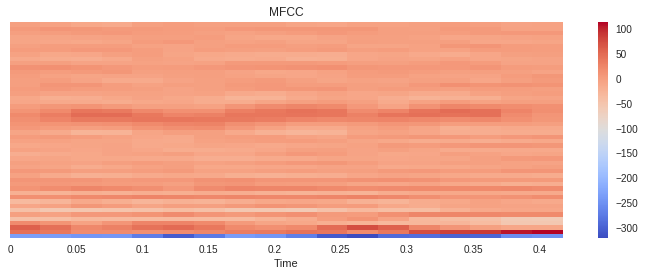

In [52]:

import librosa.display
import numpy as np

# Generate mfccs from a time series

# y, sr = librosa.load(librosa.util.example_audio_file(), offset=30, duration=5)
y, sr = librosa.load("audio/trimmedchangSaExample1.pcm.wav",sr=16000)
# librosa.feature.mfcc(y=y, sr=sr)
# array([[ -5.229e+02,  -4.944e+02, ...,  -5.229e+02,  -5.229e+02],
# [  7.105e-15,   3.787e+01, ...,  -7.105e-15,  -7.105e-15],
# ...,
# [  1.066e-14,  -7.500e+00, ...,   1.421e-14,   1.421e-14],
# [  3.109e-14,  -5.058e+00, ...,   2.931e-14,   2.931e-14]])

# Use a pre-computed log-power Mel spectrogram

# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
#                                    fmax=8000)
# librosa.feature.mfcc(S=librosa.power_to_db(S))
# array([[ -5.207e+02,  -4.898e+02, ...,  -5.207e+02,  -5.207e+02],
# [ -2.576e-14,   4.054e+01, ...,  -3.997e-14,  -3.997e-14],
# ...,
# [  7.105e-15,  -3.534e+00, ...,   0.000e+00,   0.000e+00],
# [  3.020e-14,  -2.613e+00, ...,   3.553e-14,   3.553e-14]])

# Get more components

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)

# Visualize the MFCC series

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

# Compare different DCT bases

# m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)
# m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
# plt.figure(figsize=(10, 6))
# plt.subplot(2, 1, 1)
# librosa.display.specshow(m_slaney, x_axis='time')
# plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
# plt.colorbar()
# plt.subplot(2, 1, 2)
# librosa.display.specshow(m_htk, x_axis='time')
# plt.title('HTK-style (dct_type=3)')
# plt.colorbar()
# plt.tight_layout()


# plt.figure(figsize=(14, 5))
# librosa.display.waveplot(y, sr=sr)

plt.show()




8704
[-191.92761477 -186.35792554 -182.55253326 -172.98305787 -188.92483266
 -210.27165315 -248.1192421  -271.10846165 -232.12350346 -191.21416029
 -169.72786239 -188.2725008  -222.56567315 -276.88166716 -295.6955006
 -284.3490079  -244.10682737 -236.73172289 -227.2252715  -240.94594261
 -232.46769889 -177.84361626 -371.91497781 -671.16213877 -671.16213877
 -671.16213877 -671.16213877 -671.16213877 -671.16213877 -671.16213877
 -671.16213877 -671.16213877 -671.16213877 -671.16213877 -671.16213877
 -671.16213877 -671.16213877 -671.16213877 -671.16213877 -671.16213877
 -671.16213877]
[ 56.46081221  41.56951115  34.54755987  51.01145293  27.54211197
  29.8797205   35.23983709  35.39813088  24.6646808   39.59418609
  58.69409128  67.13509409  83.52070623  53.11419387   9.26030069
  13.02181599  76.11581057  97.81488019 106.38555186 107.70666708
 102.47718247 114.35337438 114.17123546   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0. 

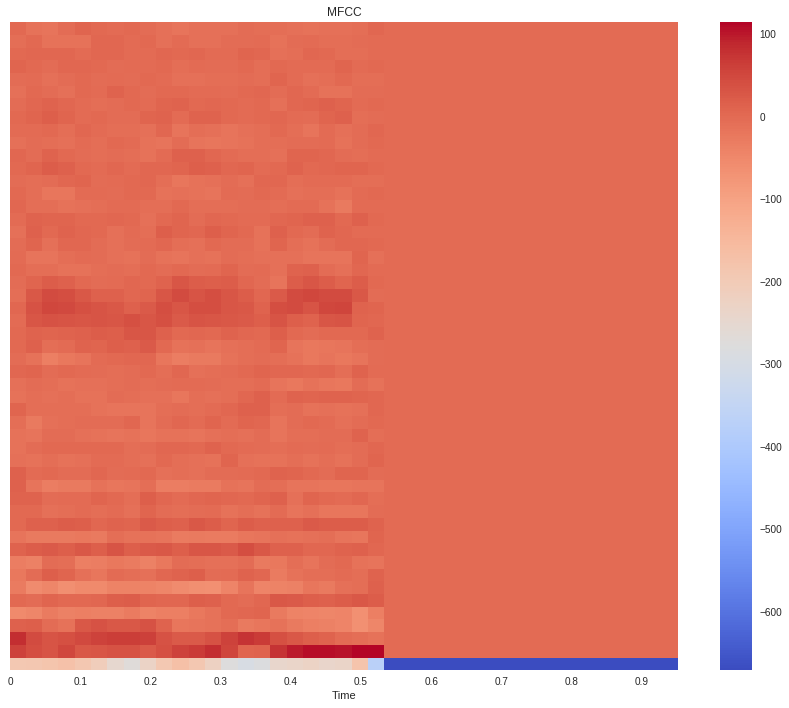

In [111]:
### Run this

from __future__ import division
import numpy as np
# import cPickle as pickle
import pandas as pd
import librosa
import math
import os

global DATADIR
global PKLDICT
global DESTDIR

def createdata(directory, **kwargs):
    duration = kwargs['dur']
    fft_win = kwargs['fft_win']
    fft_hop = kwargs['fft_hop']
    n_mfcc = kwargs['n_mfcc']

    y, sr = librosa.load(directory,16000)
    yn = y/(abs(y).max())
    k=0
    n_fft = int(round(fft_win/1000*sr))
    hop_length = int(round(fft_hop/1000*sr))

    print(y.shape[0])
    
    i=0
    j=y.shape[0]
    if j-i <= round(duration*sr):
        yseg = windowcut(yn,i,j,sr=sr,dur=duration, discard_short = kwargs['discard_short'])
        savemfcc(savetarget = "dsadjbajksd", y=yseg, sr=sr, n_mfcc=n_mfcc, n_fft = n_fft, hop_length = hop_length)
    else:
        m=0
        cut = lambda x: (2*x+1)*round(duration*sr/2)
        slices = filter(None,map(lambda n: (int(i+cut(n)-cut(0)),int(i+cut(n)+cut(0))) if i+cut(n)<j else None, range(int(math.ceil(duration*sr)))))
        for tu in slices:
            ii=int(tu[0])
            jj=int(tu[1])
            yseg = windowcut(yn,ii,jj,sr=sr,dur=duration, discard_short = kwargs['discard_short'])
            savemfcc(savetarget = "dsadjbajksd"+'_'+str(m), y=yseg, sr=sr, n_mfcc=n_mfcc, n_fft = n_fft, hop_length = hop_length)
            m+=1
    
#     savemfcc(savetarget = "dsadjbajksd", y=yn, sr=sr, n_mfcc=n_mfcc, n_fft = n_fft)
    print('Done') 


def savemfcc(savetarget, y, sr, n_mfcc,  **kwargs):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, **kwargs)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    # ALthough a test showed not much difference, by eye, it seems rescaling each is better.
    #rescale each matrix
    
    print(mfcc[0])
    print(mfcc[1])
#     print(mfcc[2])
    
#     print(mfcc[1:].min())
  
#     duration = 1
#     wincut(duration ,mfcc)
    print(mfcc.shape)
    print(mfcc_delta2.shape)
    
    # rescale from 0 to 1 
    res = np.array([rescale(mfcc[1:]),rescale(mfcc_delta[1:]),rescale(mfcc_delta2[1:])])
    print(res.shape)
    #rescale all at once (deltas will be squeezed since mfcc has larger scales)
    #res = rescale(np.array([mfcc[1:],mfcc_delta[1:],mfcc_delta2[1:]]))
    
    #### Found out that the window cut function cannot be removed.
     ## brining back the window cut function
    
    
    plt.figure(figsize=(12, 10))
    librosa.display.specshow(mfcc, x_axis='time')
#     librosa.display.specshow(res[0],x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    np.save(savetarget,res)

def windowcut(y,i,j,dur=1,sr=22050,discard_short=True):
    """ Returns a slice of y with a specified width
    dur: width of window in second
    """
    if dur < len(y)/sr:
        left = round((i+j)/2)-round(dur*sr/2)
        right = left+round(dur*sr)
        if left<0:
            left = 0
            right = round(dur*sr)
        elif right>len(y):
            right = len(y)
            left = right -  round(dur*sr)
        return y[int(left):int(right)]
    else: #discard data if total length is smaller than duration we want
        if discard_short:
            return None
        else: #padd with zeros at the end
            return np.array(np.append(y,np.zeros(round(dur*sr)-len(y))))
    
def rescale(m):
    #rescale by global max of absolute values
    offset = m.min()
    scale = m.max()-m.min()
    return (m-offset)/scale

  
createdata("audio/trimmed"+fileNameArray[0],dur=1,discard_short = False, fft_win=30,fft_hop=25, n_mfcc=13)




In [0]:
%%bash
ls

audio
datalab
dsadjbajksd.npy
trimmedchangSaExample1.pcm.wav


In [100]:
x = np.load("dsadjbajksd_0.npy")
print(x[0][1]==x.reshape((3*50,41))[1])
print(x.reshape((3*50,41))[0])


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[0.66359128 0.79289574 0.74285621 0.57751061 0.38078208 0.29837264
 0.50145816 0.62449855 0.74422754 0.73576791 0.74132757 0.7839919
 0.83590008 0.87509462 0.84803271 0.7196948  0.60250161 0.56038548
 0.61807354 0.71438695 0.82168237 0.82583094 0.75833576 0.53990828
 0.63667828 0.62533865 0.58532162 0.7070044  0.81118821 0.81578097
 0.69641871 0.62511595 0.54960934 0.52497969 0.3161135  0.18621892
 0.18774093 0.30596256 0.75598116 0.74538318 1.        ]


In [0]:
# From here on its testing dont run it 

In [0]:
tX = np.zeros(0,2,3)


In [0]:
def load_data(testsplit=0.2, setaside=False, asc=False):
    animal = {"cat":1,"dog":0}
    X=[]
    y=[]
    Xs=[]
    ys=[]
    for key in FOLDER.keys():
        directory = DATADIR+FOLDER[key]
        files = os.listdir(directory)
        Xi=[]
        for fn in sorted(files):
            x = np.load(directory+fn)
            d = x.shape[2]-3*x.shape[1] # third dimension width - 3 times second dimension
            d1 = int(round(d/2)) # divide by 2
            d2 = d - d1 # d2 is the remaining of d - d1 
            xs = x.reshape((3*x.shape[1],x.shape[2]))[:,d1:x.shape[2]-d2] # reshape filling up with, concatenate
            Xi.append(xs)
            yi = list(np.ones(len(Xi))*animal[key])
        if setaside:
            if asc:
                # setaside first consecutive files
                cutind = int(len(Xi)*testsplit)
                Xs+=Xi[:cutind]
                ys+=yi[:cutind]
                X+=Xi[cutind:]
                y+=yi[cutind:]
            else:
                #set aside last consecutive files
                cutind = -1*int(len(Xi)*testsplit)
                X+=Xi[:cutind]
                y+=yi[:cutind]
                Xs+=Xi[cutind:]
                ys+=yi[cutind:]
        else:
            X+=Xi
            y+=yi

    X = np.array(X)
    y = np.array(y).T
    if setaside: #setaside needs separate shuffling for each
        Xs = np.array(Xs)
        ys = np.array(ys).T
        Xy= zip(X,y)
        Xys= zip(Xs,ys)#np.array(map(lambda i: [Xs[i],ys[i]],range(len(ys))))
        np.random.shuffle(Xy)
        np.random.shuffle(Xys)
        X_train= np.array(map(lambda x: x[0],Xy))
        y_train= np.array(map(lambda x: x[1],Xy))
        X_test= np.array(map(lambda x: x[0],Xys))
        y_test= np.array(map(lambda x: x[1],Xys))
    else:
        X = np.array(X)
        y = np.array(y).T
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsplit)

    X_train, y_train = shaping(X_train,y_train)
    X_test, y_test = shaping(X_test,y_test)
    return X_train, X_test, y_train, y_test

In [0]:
def load_data(testsplit=0.2, balance=True, size=1000):
    animal = {"cat":1,"dog":0, 'bird':2}
    X=[]
    y=[]
    for fn in ["dsadjbajksd_0.npy","dsadjbajksd_1.npy","dsadjbajksd.npy"]:
#         directory = DATADIR+FOLDER[key]
#         files = os.listdir(directory)
        Xi=[]

#         if balance:
#             files = choice(files, size)

#         for fn in files:
        x = np.load("audio/"+fn)
        # wanted to reshape into a square
        # first trying to put importance in the center data
        # calculate the number of data to be deleted at the left right
        # so for (3,41,50) its impossible because the data is rectangle and longer at its verticle side to make square and not losing verticle data we will need to do padding which is quite meaning less, 
        # the resulting ndarray should be (150,41)
        # what we want is that 
        # the (3,41,13) so that it can become (3*13,41) then become (39,39) after removing the two 
        d = x.shape[2]-3*x.shape[1]
        d1 = int(round(d/2))
        d2 = d-d1
        xs = x.reshape((3*x.shape[1],x.shape[2]))[:,d1:x.shape[2]-d2]
        Xi.append(xs)
        yi = list(np.ones(len(Xi))*animal[key])

        X+=Xi # the difference between  += and .append() is that += is like extend() which add two array like [a] += [b] // [a,b] but [a].append([b,c]) will give you [a,[b,c]]
        y+=yi

    X = np.array(X)
    y = np.array(y).T

    X = np.array(X)
    y = np.array(y).T
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsplit)

    X_train, y_train = shaping(X_train,y_train)
    X_test, y_test = shaping(X_test,y_test)
    return X_train, X_test, y_train, y_test

def shaping(X,y):
    X_new = X.reshape((X.shape[0],1,X[0].shape[1],X.shape[2]))
    y_new = np_utils.to_categorical(y,3)
    return X_new, y_new

load_data()


## Reference
1. [Noise Reduction And Audio Trimming](https://github.com/dodiku/noise_reduction)
2. [Converting PCM to WAV](https://stackoverflow.com/questions/16111038/how-to-convert-pcm-files-to-wav-files-scripting)